<img src=https://littleml.files.wordpress.com/2016/09/stadsdelen-amsterdam.png width = 500 align="left">
<h1 align=center><font size=5>AMSTERDAM<br><br>NEIGHBORHOODS</font></h1>
<h2 align=center><font size=4>-</font></h2>
<h2 align=center><font size=4>July 2020</font></h2>
<h2 align=center><font size=4><a href="https://www.linkedin.com/in/dgallo88/">Daniel Gallo Sánchez</a></font></h2>


## Introduction
In this notebook I will convert Amsterdam's neighborhoods into their equivalent latitude and longitude values. Also, I will use the Foursquare API to explore these neighborhoods. I will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. I will use the *k*-means clustering algorithm to complete this task. Finally, I will use the Folium library to visualize the neighborhoods in Amsterdam and their emerging clusters.

## Table of Contents

<div style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in Amsterdam</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [47]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported!!!')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported!!!


<a id='item1'></a>

## 1. Download and Explore Dataset

In order to segement Amsterdam neighborhoods and explore them, we will essentially need a dataset that contains the name of these neighborhoods as well as the the latitude and logitude coordinates of each neighborhood. Luckily, this information exists for free on the web at:  
https://www.amsterdam.nl/en/districts/  

Amsterdam is divided into *7 districts* and each district is divided into neighbourhoods. Amsterdam has *26 neighbourhoods* in total.

I put the name of the neighborhoods in an Excel documents and upload the file to GitHub. Another option it would be to use Postal Codes, but doing this analysis with the names of the neighborhoods is more comprenhensive. Let's have a look at Amsterdam districts and neighboorhoods. 

In [95]:
neighborhoods_data = pd.read_excel('https://github.com/dgallo88/Amsterdam_Neighborhoods/raw/master/Amsterdam_Districts_and_Neighborhoods.xlsx')
neighborhoods_data

,District,Neighborhood
0,Centre,Centrum-Oost
1,Centre,Centrum-West
2,West,De Baarsjes
3,West,Oud-West
4,West,Westerpark
5,West,Bos en Lommer
6,Nieuw-West,Geuzenveld
7,Nieuw-West,Slotermeer
8,Nieuw-West,Sloterdijken
9,Nieuw-West,Slotervaart


Let's check the type of the data.

In [96]:
print (neighborhoods_data.dtypes)

District        object
Neighborhood    object
dtype: object


The type in the data frame is an *object*, let's change it to *string* for our own convenience later on. 

In [97]:
neighborhoods_data[["District"]] = neighborhoods_data[["District"]].astype('string')
neighborhoods_data[["Neighborhood"]] = neighborhoods_data[["Neighborhood"]].astype('string')
print (neighborhoods_data.dtypes)

District        string
Neighborhood    string
dtype: object


Now that we have built a dataframe of the districts and neighborhood names, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. We will use the *geopy* library for this purpuse.

In order to define an instance of the geocoder, we need to define a *user_agent*. We will name our agent *ams_explorer*, as shown below.

In [98]:
neighborhoods =  pd.DataFrame(columns=['District','Neighborhood', 'Latitude', 'Longitude'])
geolocator = Nominatim(user_agent='ams_explorer')

for index, row in neighborhoods_data.iterrows():
    district_name = row['District']
    neighborhood_name = row['Neighborhood']
    address = neighborhood_name + ', Amsterdam, Noord-Holland, Nederland'  
    location = geolocator.geocode(address)
    if location is None:
        latitude = None
        longitude = None
    else:
        latitude = location.latitude
        longitude = location.longitude
    neighborhoods = neighborhoods.append({'District': district_name,'Neighborhood': str(neighborhood_name), 'Latitude': latitude, 'Longitude': longitude}, ignore_index=True)
    print('{}: {}'.format(index, neighborhood_name))
    print('location: {}'.format(location))
    print('{}: {}, {}.'.format('coordinates: ', latitude, longitude)) 

0: Centrum-Oost
location: CWI, Science Park, Watergraafsmeer, Amsterdam, Noord-Holland, Nederland, 1098 XG, Nederland
coordinates: : 52.356509700000004, 4.952102635783275.
1: Centrum-West
location: Centrum, Amsterdam, Noord-Holland, Nederland, 1012JK, Nederland
coordinates: : 52.3737301, 4.8956908.
2: De Baarsjes
location: De Baarsjes, Amsterdam, Noord-Holland, Nederland, 1057WX, Nederland
coordinates: : 52.3689257, 4.8563825.
3: Oud-West
location: Oud-West, Amsterdam, Noord-Holland, Nederland
coordinates: : 52.36481465, 4.869761930307041.
4: Westerpark
location: Westerpark, Amsterdam, Noord-Holland, Nederland
coordinates: : 52.387236349999995, 4.871777328438663.
5: Bos en Lommer
location: Bos en Lommer, Amsterdam, Noord-Holland, Nederland, 1055DZ, Nederland
coordinates: : 52.3785206, 4.8487385.
6: Geuzenveld
location: Geuzenveld, Amsterdam, Noord-Holland, Nederland, 1067JR, Nederland
coordinates: : 52.3783939, 4.8016275.
7: Slotermeer
location: Slotermeer, Amsterdam, Noord-Holland, Ne

In [99]:
neighborhoods

,District,Neighborhood,Latitude,Longitude
0,Centre,Centrum-Oost,52.356510,4.952103
1,Centre,Centrum-West,52.373730,4.895691
2,West,De Baarsjes,52.368926,4.856382
3,West,Oud-West,52.364815,4.869762
4,West,Westerpark,52.387236,4.871777
5,West,Bos en Lommer,52.378521,4.848738
6,Nieuw-West,Geuzenveld,52.378394,4.801628
7,Nieuw-West,Slotermeer,52.377961,4.821952
8,Nieuw-West,Sloterdijken,NaN,NaN
9,Nieuw-West,Slotervaart,52.361286,4.827466


### Dealing with missing data

Let's see how many elemens in the data frame are with *Latitude* and *Longitude* equal to *NaN*

In [100]:
null_values_df = neighborhoods[neighborhoods['Latitude'].isnull().values]
null_values_df

,District,Neighborhood,Latitude,Longitude
8,Nieuw-West,Sloterdijken,NaN,NaN
31,Oud-Noord,Noordelijke IJ-oever,NaN,NaN
35,Zuid Oost,Amstel lll,NaN,NaN
37,Zuid Oost,Bijlmer-Centrum,NaN,NaN
38,Zuid Oost,Bijlmer-Oost,NaN,NaN


In [101]:
null_values_df.shape[0]

5

There are 5 neighborhoods with empty coordinates. Nominatim (in the background Open Street Map) cannot retrieve theirs coordinates. As there are only 5 neighborhoods missing their latitude and longitude, I am going to look up those values on the internet and replace it with the right coordinates. Moreover, I am fixing 3 others coordinates to point to the center of those 3 neighborhoods.

In [102]:
neighborhoods.loc[neighborhoods['Neighborhood']=='Sloterdijken', ['Latitude', 'Longitude']] = [52.3871,4.8465] 
neighborhoods.loc[neighborhoods['Neighborhood']=='Noordelijke IJ-oever', ['Latitude', 'Longitude']] = [52.3923, 4.9014]
neighborhoods.loc[neighborhoods['Neighborhood']=='Amstel lll', ['Latitude', 'Longitude']] = [52.2952,4.9460] 
neighborhoods.loc[neighborhoods['Neighborhood']=='Bijlmer-Centrum', ['Latitude', 'Longitude']] = [52.3170,4.9650]
neighborhoods.loc[neighborhoods['Neighborhood']=='Bijlmer-Oost', ['Latitude', 'Longitude']] = [52.3169,4.9801]

#fixing some incorrect coordinates
neighborhoods.loc[neighborhoods['Neighborhood']=='Centrum-Oost', ['Latitude', 'Longitude']] = [52.36456,4.90678]
neighborhoods.loc[neighborhoods['Neighborhood']=='Waterland', ['Latitude', 'Longitude']] = [52.39345,4.99409]
neighborhoods.loc[neighborhoods['Neighborhood']=='Oud-Oost', ['Latitude', 'Longitude']] = [52.35999,4.92523]

neighborhoods

,District,Neighborhood,Latitude,Longitude
0,Centre,Centrum-Oost,52.364560,4.906780
1,Centre,Centrum-West,52.373730,4.895691
2,West,De Baarsjes,52.368926,4.856382
3,West,Oud-West,52.364815,4.869762
4,West,Westerpark,52.387236,4.871777
5,West,Bos en Lommer,52.378521,4.848738
6,Nieuw-West,Geuzenveld,52.378394,4.801628
7,Nieuw-West,Slotermeer,52.377961,4.821952
8,Nieuw-West,Sloterdijken,52.387100,4.846500
9,Nieuw-West,Slotervaart,52.361286,4.827466


Let's now show the neighborhoods on a map, but first we need Amsterdam coordinates.

In [103]:
address = 'Amsterdam, Noord-Holland, Nederland'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Amsterdam are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Amsterdam are 52.37454030000001, 4.897975505617977.


Let's create a map of Amsterdam with neighborhoods superimposed on top. Neighborhoods of the same color on this map belong to the same district.

In [104]:
# create map of Amsterddam using latitude and longitude values
map_ams = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the Districts
districs = neighborhoods['District'].unique()
kclusters = len(districs)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

# add markers to map
for lat, lng, district, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['District'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=500,
        popup=label,
        color=rainbow[np.where(districs==district)[0][0]],
        fill=True,
        fill_color=rainbow[np.where(districs==district)[0][0]],
        fill_opacity=0.7,
        parse_html=False).add_to(map_ams)  
    
map_ams

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective district.

Next, we are going to start utilizing the **Foursquare API** to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [ ]:
# @hidden_cell

CLIENT_ID = 'JMWOIVHGTJLVU0Q01P05GKLX2OCPUXINZLWVW4KYBFE3DLT0' # your Foursquare ID
CLIENT_SECRET = '01JPYMX0ECILJTS0HD232N02XDFX1TSF0WCFYTVZBUZO5GO1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

<a id='item2'></a>

## 2. Explore Neighborhoods in Amsterdam

Let's create a function to explore all the neighborhoods in Amsterdam using the *Foursquare API*. The request to Foursquare will returns a list of recommended venues near the location of the neighborhoods. 


In [138]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
            
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name + ':')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        print('{} {}'.format(len(results), 'venues found'))
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's now write the code to run the above function on each neighborhood and create a new dataframe called *amsterdam_venues*.

In [107]:
amsterdam_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                   radius=500,
                                   limit=100
                                   )

Centrum-Oost:
95 venues found
Centrum-West:
100 venues found
De Baarsjes:
62 venues found
Oud-West:
100 venues found
Westerpark:
48 venues found
Bos en Lommer:
48 venues found
Geuzenveld:
13 venues found
Slotermeer:
29 venues found
Sloterdijken:
13 venues found
Slotervaart:
10 venues found
De Aker:
11 venues found
Sloten:
11 venues found
Nieuw-Sloten:
6 venues found
Osdorp:
24 venues found
Buitenveldert:
45 venues found
Zuidas:
42 venues found
Rivierenbuurt:
52 venues found
De Pijp:
100 venues found
Oud-Zuid:
61 venues found
Banne Buiksloot:
12 venues found
Kadoelen:
4 venues found
Oostzanerwerf:
11 venues found
Tuindorp Oostzaan:
8 venues found
Buikslotermeer:
28 venues found
Elzenhagen:
0 venues found
Waterland:
4 venues found
Waterlandpleinbuurt:
10 venues found
Buiksloterdijk:
13 venues found
Nieuwendammerdijk:
6 venues found
Ijplein:
21 venues found
Vogelbuurt:
19 venues found
Noordelijke IJ-oever:
9 venues found
Tuindorp Buiksloot:
8 venues found
Tuindorp Nieuwendam:
5 venues fou

Let's check the size of the resulting dataframe

In [108]:
print(amsterdam_venues.shape)
amsterdam_venues.head()

(1253, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centrum-Oost,52.36456,4.90678,Zoku,52.363891,4.906723,Hotel
1,Centrum-Oost,52.36456,4.90678,Dignita Hoftuin,52.365608,4.904464,Tea Room
2,Centrum-Oost,52.36456,4.90678,HIGH STUDIOS,52.364273,4.906484,Gym / Fitness Center
3,Centrum-Oost,52.36456,4.90678,Delight Yoga,52.362259,4.905868,Yoga Studio
4,Centrum-Oost,52.36456,4.90678,De Hortus,52.366952,4.907511,Botanical Garden


For the sake of formality let's check that we do not have any duplicated place.

In [148]:
print(amsterdam_venues[amsterdam_venues.duplicated()].shape)
amsterdam_venues[amsterdam_venues.duplicated()]

(0, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


Let's check how many venues were returned for each neighborhood.

In [110]:
amsterdam_venues.groupby('Neighborhood').count().reset_index()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amstel lll,14,14,14,14,14,14
1,Banne Buiksloot,12,12,12,12,12,12
2,Bijlmer-Centrum,5,5,5,5,5,5
3,Bijlmer-Oost,8,8,8,8,8,8
4,Bos en Lommer,48,48,48,48,48,48
5,Buiksloterdijk,13,13,13,13,13,13
6,Buikslotermeer,28,28,28,28,28,28
7,Buitenveldert,45,45,45,45,45,45
8,Bullewijk,18,18,18,18,18,18
9,Centrum-Oost,95,95,95,95,95,95


Let's plot this using a histogram to see the distribution of the venues.

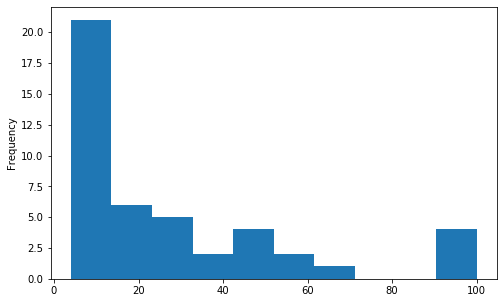

In [111]:
amsterdam_venues.groupby('Neighborhood').count()['Venue'].plot(kind='hist', figsize=(8, 5))

In [112]:
amsterdam_venues.groupby('Neighborhood').count().shape

(45, 6)

Let's find out how many unique categories can be curated from all the returned venues

In [113]:
print('There are {} uniques categories.'.format(len(amsterdam_venues['Venue Category'].unique())))
amsterdam_venues['Venue Category'].unique()

There are 235 uniques categories.


array(['Hotel', 'Tea Room', 'Gym / Fitness Center', 'Yoga Studio',
       'Botanical Garden', 'Restaurant', 'Theater', 'Art Museum',
       'Pool Hall', 'Breakfast Spot', 'Indie Movie Theater', 'Café',
       'Coworking Space', 'Bakery', 'Bar', 'Pizza Place',
       'French Restaurant', 'Plaza', 'Bistro', 'Sandwich Place',
       'History Museum', 'Beer Bar', 'Opera House', 'Greek Restaurant',
       'Science Museum', 'Smoke Shop', 'Boat or Ferry', 'Bridge',
       'Ice Cream Shop', 'Coffee Shop', 'Bagel Shop', 'Park',
       'Indonesian Restaurant', 'Burger Joint',
       'South American Restaurant', 'Marijuana Dispensary', 'Canal',
       'Japanese Restaurant', 'General Entertainment', 'Recording Studio',
       'Museum', 'Diner', 'Indoor Play Area', 'Cocktail Bar', 'Hostel',
       'Italian Restaurant', 'Supermarket', 'Snack Place',
       'Convenience Store', 'Chinese Restaurant', 'Steakhouse',
       'Liquor Store', 'Salon / Barbershop', 'Cheese Shop',
       'Dessert Shop', 'Choc

Let's see how many venues we have in each category.

In [114]:
amsterdam_venues['Venue Category'].value_counts()

Café                             57
Restaurant                       52
Coffee Shop                      51
Bar                              49
Supermarket                      44
Hotel                            43
Italian Restaurant               35
Bus Stop                         30
Bakery                           30
Snack Place                      24
Park                             22
Plaza                            21
Pizza Place                      19
Grocery Store                    16
Turkish Restaurant               15
Ice Cream Shop                   14
Indonesian Restaurant            14
Fast Food Restaurant             14
Drugstore                        14
French Restaurant                13
Asian Restaurant                 12
Gym / Fitness Center             12
Chinese Restaurant               11
Breakfast Spot                   11
Burger Joint                     11
Tram Station                     11
Market                           10
Pharmacy                    

<a id='item3'></a>

## 3. Analyze Each Neighborhood

We are going to make use of the one hot encoding to transform the dataset. Each row represents a venue in the neighborhood with 1 in the column that represent the category of the venue. The rest will be filled in with 0. 

In [115]:
# one hot encoding
amsterdam_onehot = pd.get_dummies(amsterdam_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
amsterdam_onehot['Neighborhood'] = amsterdam_venues['Neighborhood'] 

# move neighborhood column to the first column
col_name = "Neighborhood"
first_col = amsterdam_onehot.pop(col_name)
amsterdam_onehot.insert(0, col_name, first_col)

amsterdam_onehot.head()

,Neighborhood,Accessories Store,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Canal,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Dairy Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health Food Store,History Museum,Hockey Field,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Latin American Restaurant,Lawyer,Lebanese Restaurant,Liquor Store,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Venue,Nightclub,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Supply Store,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rest Area,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Science Museum,Seafood Restaurant,Shop & Service,Shopping Mall,Skate Park,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Centrum-Oost,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Centrum-Oost,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

And let's examine the new dataframe size.

In [116]:
amsterdam_onehot.shape

(1253, 235)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category. 

In [117]:
amsterdam_grouped = amsterdam_onehot.groupby('Neighborhood').mean().reset_index()
amsterdam_grouped

,Neighborhood,Accessories Store,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Canal,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Dairy Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health Food Store,History Museum,Hockey Field,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Latin American Restaurant,Lawyer,Lebanese Restaurant,Liquor Store,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Venue,Nightclub,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Supply Store,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rest Area,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Science Museum,Seafood Restaurant,Shop & Service,Shopping Mall,Skate Park,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Amstel lll,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00

#### Let's confirm the new size

In [118]:
amsterdam_grouped.shape

(45, 235)

Let's print each neighborhood along with the top 10 most common venues for your reference.

In [199]:
num_top_venues = 10

for hood in amsterdam_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp = amsterdam_grouped[amsterdam_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp_ordered = temp.sort_values('freq', ascending=False).reset_index(drop=True)
    print(temp_ordered[temp_ordered['freq'] != 0.00].head(num_top_venues))
    print('\n')

---- Amstel lll ----
                  venue  freq
0            Restaurant  0.21
1   Rental Car Location  0.14
2                   Gym  0.07
3            Food Court  0.07
4   Fried Chicken Joint  0.07
5  Fast Food Restaurant  0.07
6                Bistro  0.07
7        Sandwich Place  0.07
8             Hotel Bar  0.07
9      Asian Restaurant  0.07


---- Banne Buiksloot ----
                venue  freq
0            Bus Stop  0.25
1                Park  0.17
2         Supermarket  0.17
3       Shopping Mall  0.08
4    Business Service  0.08
5          Restaurant  0.08
6  Turkish Restaurant  0.08
7              Bakery  0.08


---- Bijlmer-Centrum ----
      venue  freq
0      Park   0.6
1  Bus Stop   0.2
2   Theater   0.2


---- Bijlmer-Oost ----
                  venue  freq
0           Supermarket  0.25
1         Shopping Mall  0.12
2     Food & Drink Shop  0.12
3              Bus Stop  0.12
4        Discount Store  0.12
5                Bakery  0.12
6  Fast Food Restaurant  0.12


--

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [216]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    row_categories_sorted.index.values[row_categories_sorted==0.0]= None   #to delete categories with frequency equals to 0
       
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [218]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = amsterdam_grouped['Neighborhood']

for ind in np.arange(amsterdam_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(amsterdam_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amstel lll,Restaurant,Rental Car Location,Fast Food Restaurant,Fried Chicken Joint,Bistro,Gym,Hotel,Hotel Bar,Asian Restaurant,Sandwich Place
1,Banne Buiksloot,Bus Stop,Supermarket,Park,Business Service,Shopping Mall,Bakery,Turkish Restaurant,Restaurant,None,None
2,Bijlmer-Centrum,Park,Bus Stop,Theater,None,None,None,None,None,None,None
3,Bijlmer-Oost,Supermarket,Discount Store,Bakery,Food & Drink Shop,Shopping Mall,Fast Food Restaurant,Bus Stop,None,None,None
4,Bos en Lommer,Food & Drink Shop,Gym,Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Turkish Restaurant,Fast Food Restaurant,Supermarket,Bakery,Park
5,Buiksloterdijk,Soccer Field,Café,Gym Pool,Park,Gym,Hotel,Farm,Rest Area,Pool,Monument / Landmark
6,Buikslotermeer,Electronics Store,Supermarket,Sandwich Place,Seafood Restaurant,Sporting Goods Shop,Restaurant,Mobile Phone Shop,Japanese Restaurant,Brasserie,Drugstore
7,Buitenveldert,Hotel,Restaurant,Grocery Store,Coffee Shop,Drugstore,Sandwich Place,Supermarket,Sushi Restaurant,Bakery,Persian Restaurant
8,Bullewijk,Hotel,Café,Restaurant,Brewery,Office,Fast Food Restaurant,Cafeteria,Scandinavian Restaurant,Food & Drink Shop,Furniture / Home Store
9,Centrum-Oost,Bar,Hotel,Café,Restaurant,Coffee Shop,French Restaurant,Pizza Place,Plaza,Bakery,Theater


<a id='item4'></a>

## 4. Cluster Neighborhoods

Below is the dataset that we are going to use to cluster Amsterdam neighborhoods based on the category of the most popular places.

In [219]:
amsterdam_grouped_clustering = amsterdam_grouped.drop('Neighborhood', 1)
amsterdam_grouped_clustering

,Accessories Store,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Canal,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Dairy Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health Food Store,History Museum,Hockey Field,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Latin American Restaurant,Lawyer,Lebanese Restaurant,Liquor Store,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Venue,Nightclub,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Supply Store,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rest Area,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Science Museum,Seafood Restaurant,Shop & Service,Shopping Mall,Skate Park,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0

The KMeans class has many parameters that can be used, but we will be using these three:
<ul>
    <li> <b>init</b>: Initialization method of the centroids. </li>
    <ul>
        <li> Value will be: "k-means++" </li>
        <li> k-means++: Selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.</li>
    </ul>
    <li> <b>n_clusters</b>: The number of clusters to form as well as the number of centroids to generate. </li>
    <ul> <li> Value will be: 5</li> </ul>
    <li> <b>n_init</b>: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia. </li>
    <ul> <li> Value will be: 12 </li> </ul>
</ul>

But, how can we choose right value for *k*? The general solution is to run *k*-means with different values for *k*, and choose the *k* that is the best for the model.  
For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.

In [ ]:
# Best k
Ks=45
Sum_of_squared_distances =  np.zeros((Ks-1))

#Run k-means with different Ks 
for k in range(1,Ks):
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12, random_state=0).fit(amsterdam_grouped_clustering)    
    Sum_of_squared_distances[k-1]=k_means.inertia_
    
Sum_of_squared_distances

As k increases, the sum of squared distance tends to zero. Imagine we set k to its maximum value n (where n is number of samples) each sample will form its own cluster meaning sum of squared distances equals zero.

Below is a plot of sum of squared distances for k in the range specified above. If the plot looks like an arm, then the elbow on the arm is optimal k.

In [ ]:
k= range(1,Ks)

fig = plt.figure()
fig.set_figwidth(12) # set width
fig.set_figheight(6) # set height

plt.plot(k, Sum_of_squared_distances,'o-')
plt.title('Elbow Method For Optimal k')
plt.ylabel('Sum_of_squared_distances')
plt.xlabel('k')
plt.tight_layout()
plt.xticks(k,k)
plt.show()

Let's use now the Silhoutte method to determine the best value for *k*.  

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [ ]:
from sklearn.metrics import silhouette_score 

# Best k
Ks=45
silhouette_list =  np.zeros((Ks-2))

#Run k-means with different Ks 
for k in range(2,Ks):
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12, random_state = 0).fit(amsterdam_grouped_clustering)    
    silhouette_list[k-2] = silhouette_score(amsterdam_grouped_clustering, k_means.labels_)
    
silhouette_list

In [ ]:
k= range(2,Ks)

fig = plt.figure()
fig.set_figwidth(12) # set width
fig.set_figheight(6) # set height

plt.plot(k, silhouette_list,'o-')
plt.title('silhouette_score')
plt.ylabel('silhouette_score')
plt.xlabel('k')
plt.tight_layout()
plt.xticks(k,k)
plt.show()

Let's try now with **Agglomerative Clustering**

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Best k
Ks=45
silhouette_list =  np.zeros((Ks-2))

#Run k-means with different Ks 
for k in range(2,Ks):
    clusterer = AgglomerativeClustering(n_clusters = k, linkage='average').fit(amsterdam_grouped_clustering)    
    silhouette_list[k-2] = silhouette_score(amsterdam_grouped_clustering, clusterer.labels_)
    
silhouette_list

In [ ]:
k= range(2,Ks)

fig = plt.figure()
fig.set_figwidth(12) # set width
fig.set_figheight(6) # set height

plt.plot(k, silhouette_list,'o-')
plt.title('silhouette_score')
plt.ylabel('silhouette_score')
plt.xlabel('k')
plt.tight_layout()
plt.xticks(k,k)
plt.show()

In [ ]:
# set number of clusters
kclusters = 10
k_means = AgglomerativeClustering(n_clusters = kclusters, linkage='ward')
# run k-means clustering
k_means.fit(amsterdam_grouped_clustering)

# check cluster labels generated for each row in the dataframe
k_means.labels_

In [ ]:
from scipy.spatial import distance_matrix 
dist_matrix = distance_matrix(amsterdam_grouped_clustering,amsterdam_grouped_clustering) 
df = pd.DataFrame(data=dist_matrix)
df.describe()

In [ ]:
from scipy.cluster import hierarchy 
import pylab

Z = hierarchy.linkage(dist_matrix, 'ward')

fig = pylab.figure(figsize=(18,10))

dendro = hierarchy.dendrogram(Z)

Let's try now with **DBSCAN** (Density-Based Spatial Clustering of Applications of Noise )

In [ ]:
from sklearn.cluster import DBSCAN

epsilon = 0.4
minimumSamples = 7
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(amsterdam_grouped_clustering)
labels = db.labels_


unique, counts = np.unique(db.labels_, return_counts=True)
for u, c in zip(unique, counts):
    print ('{}:{}'.format(u,c))

***KMEANS!!!!!***

In the plot above the elbow is at k=7 indicating the optimal k for this dataset is 7.  
Let's cluster now the neighborhoods in 7 groups. 

In [ ]:
'''# set number of clusters
kclusters = 2
k_means = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 12)
# run k-means clustering
k_means.fit(amsterdam_grouped_clustering)

# check cluster labels generated for each row in the dataframe
k_means.labels_
'''

In [ ]:
unique, counts = np.unique(k_means.labels_, return_counts=True)
for u, c in zip(unique, counts):
    print ('{}:{}'.format(u,c))

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [ ]:
# add clustering labels
neighborhoods_venues_labeled = neighborhoods_venues_sorted.copy()
neighborhoods_venues_labeled.insert(0, 'Cluster Labels', k_means.labels_)

amsterdam_merged = neighborhoods.copy()

# merge neighborhoods_venues_labeled with neighborhoods to add latitude/longitude for each neighborhood
amsterdam_merged = amsterdam_merged.join(neighborhoods_venues_labeled.set_index('Neighborhood'), on='Neighborhood')

amsterdam_merged.head() # check the last columns!

In [ ]:
amsterdam_merged['Cluster Labels'].value_counts()

Finally, let's visualize the resulting clusters

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(amsterdam_merged['Latitude'], amsterdam_merged['Longitude'], amsterdam_merged['Neighborhood'], amsterdam_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. We will start counting from **Cluster 0**. I will leave this exercise to you.

#### Cluster 0

In [ ]:
amsterdam_merged.loc[amsterdam_merged['Cluster Labels'] == 0, amsterdam_merged.columns[[1] + list(range(5, amsterdam_merged.shape[1]))]]

Cluster 1

In [ ]:
amsterdam_merged.loc[amsterdam_merged['Cluster Labels'] == 1, amsterdam_merged.columns[[1] + list(range(5, amsterdam_merged.shape[1]))]]

Cluster 2

In [ ]:
amsterdam_merged.loc[amsterdam_merged['Cluster Labels'] == 2, amsterdam_merged.columns[[1] + list(range(5, amsterdam_merged.shape[1]))]]

Cluster 3

In [ ]:
amsterdam_merged.loc[amsterdam_merged['Cluster Labels'] == 3, amsterdam_merged.columns[[1] + list(range(5, amsterdam_merged.shape[1]))]]

Cluster 4

In [ ]:
amsterdam_merged.loc[amsterdam_merged['Cluster Labels'] == 4, amsterdam_merged.columns[[1] + list(range(5, amsterdam_merged.shape[1]))]]